In [1]:
import pandas as pd
import numpy as np

### 1. Data Set DownLoad

In [2]:
kospi_data = pd.read_csv('./data/track1/final_kospi.csv',  na_values = ['?', '??', 'N/A', 'NA', 'nan', 'NaN', '-nan', '-NaN', 'null', '-'])
kosdaq_data = pd.read_csv('./data/track1/final_kosdaq.csv')

In [3]:
len(kospi_data[kospi_data['날짜'] > '2021-01-01'] )

138355

In [4]:
# processed_kospi_data = kospi_data.copy(deep=True)
processed_kospi_data = kospi_data[kospi_data['날짜'] > '2021-01-01']
processed_kospi_data = processed_kospi_data.drop(columns=['Unnamed: 0'], inplace=False)

unnecessary_columns = ['시가', '고가', '저가', 'code_x', 'code_y'] # 날짜 CODE 정보는 추후 분석을 위해 남겨 둠 #종가 feature 추가
processed_kospi_data = processed_kospi_data.drop(columns=unnecessary_columns, inplace=False)
processed_kospi_data = processed_kospi_data.dropna(axis=0) # null 값 제거
for col_name in processed_kospi_data.columns :
    processed_kospi_data = processed_kospi_data[processed_kospi_data[col_name] != '-']
processed_kospi_data = processed_kospi_data.reset_index(drop=True)
strict=False

len(processed_kospi_data)

127494

### 2. Split Data Set
Split by 60% train data, 20% valid data, 20% test data

In [5]:
import sklearn
from sklearn.model_selection import train_test_split

x = processed_kospi_data.copy().drop(columns=['Y'], inplace=False)
y = processed_kospi_data['Y']

x_train, x_remain, y_train, y_remain = train_test_split(x, y, train_size = 0.6)
x_valid, x_test, y_valid, y_test = train_test_split(x_remain, y_remain, train_size=0.5)

x_train = x_train.reset_index(drop=True)
x_valid = x_valid.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [6]:
print(x_train.columns)

Index(['BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS', '날짜', '종가', '거래량', '시가총액',
       '금리', 'CODE', '유동자산', '비유동자산', '자산총계', '유동부채', '비유동부채', '부채총계', '이익잉여금',
       '자본총계', '매출액', '영업이익', '법인세차감전 순이익', '당기순이익', '자본금'],
      dtype='object')


### 3. Visualization Features of Train Data

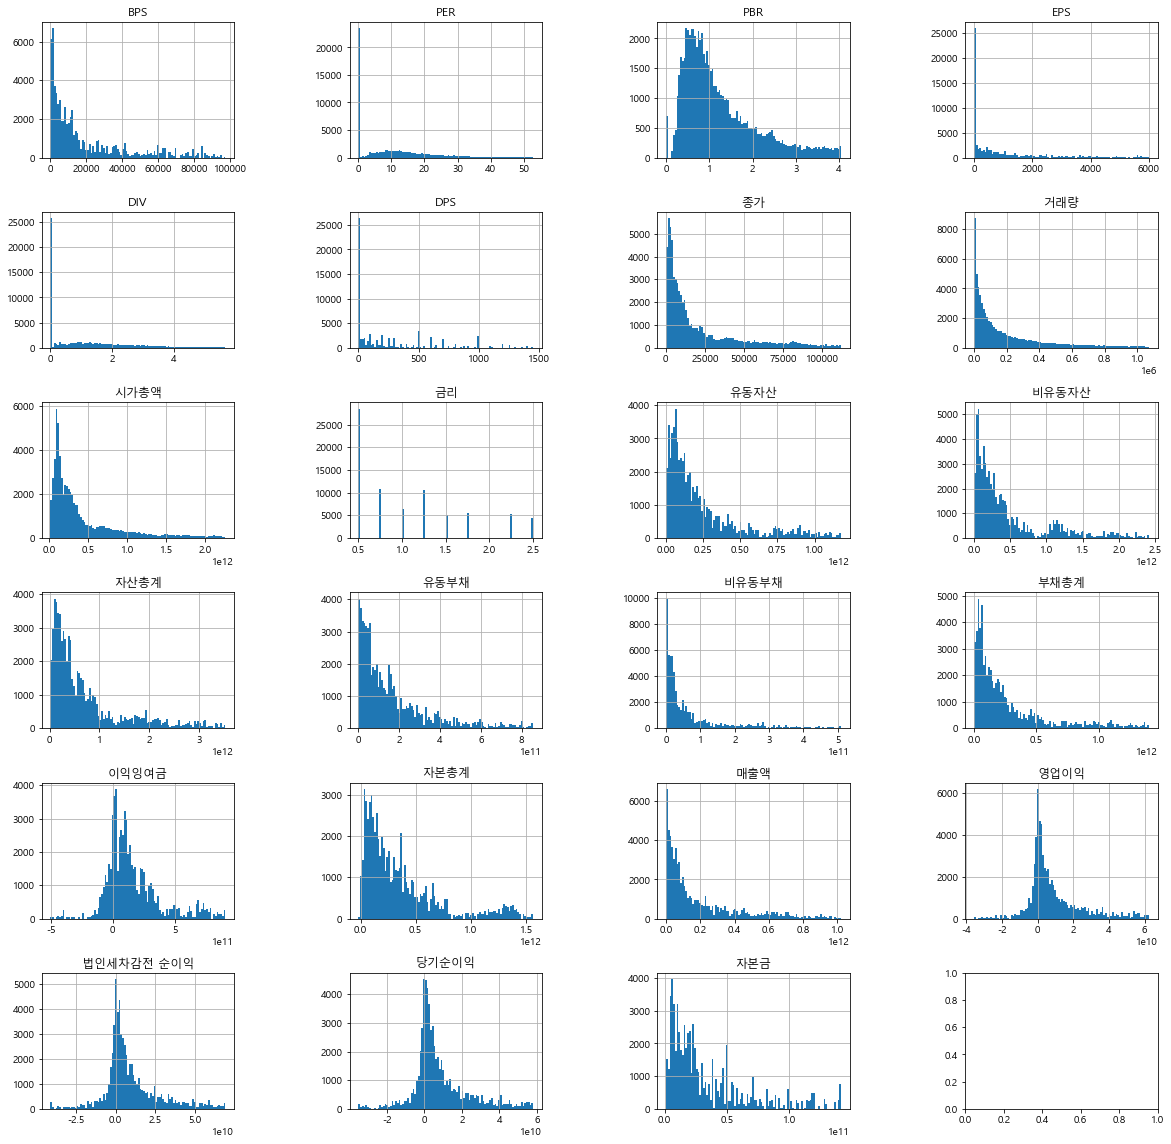

In [6]:
import matplotlib.pyplot as plt

def print_x_features(x) :
    x_features = x.drop(columns=['날짜', 'CODE'], inplace=False)

    plt.rc('font', family='Malgun Gothic')
    f, axes = plt.subplots(6, 4)
    f.set_size_inches((20,20))
    plt.subplots_adjust(wspace = 0.6, hspace=0.4)
    plt.rcParams['axes.unicode_minus'] = False

    idx = 1
    for col_name, item in x_features.iteritems():
        plt.subplot(6, 4, idx)
        plt.title(col_name)
        idx = idx + 1
        data_flat_IQR = x_features[col_name].quantile(0.75) - x_features[col_name].quantile(0.25)
        lower_bound_condition = (x_features[col_name] > x_features[col_name].quantile(0.25) - data_flat_IQR * 1.5)  # 2.7a
        upper_bound_condition = (x_features[col_name] < x_features[col_name].quantile(0.75) + data_flat_IQR * 1.5)
        df_conditions = (lower_bound_condition & upper_bound_condition)
        x_features.loc[df_conditions, col_name].hist(bins=100)

print_x_features(x_train)

### 3. Data Normalization and Visualization

In [7]:
## iqr 을 적용하여 outlier를 제외한 평균 분산 값으로 정규화
## log transform을 추가하였음

def log_transform(x) :
    return np.log(x + 1)

def log_has_min_transform(x) :
    return x.apply(lambda t: np.log(t+1) if t > 0 else t)

def calc_statistic (x) : 
    return (x.mean(), x.std()) ## 정규화 후 데이터 분포가 너무 좁아져서 수정
    x_IQR = x.quantile(0.75) - x.quantile(0.25)
    lower_bound = (x > x.quantile(0.25) - x_IQR * 1.5) ## -2.7σ in Gaussian (if x ~ Gaussian)
    upper_bound = (x < x.quantile(0.75) + x_IQR * 1.5) ## 2.7σ in Gaussian
    bound_conditions = lower_bound & upper_bound
    x_clean = x.loc[bound_conditions]
    return (x_clean.mean(), x_clean.std())

normal_distribution_list = ['PER', 'DIV', 'DPS', '이익잉여금', '영업이익', '법인세차감전', '순이익', '당기순이익', '자본금']

x_normalized_train = pd.DataFrame()
x_normalized_valid = pd.DataFrame()
x_normalized_test = pd.DataFrame()


for col_name in x_train.columns :
    if col_name in ['CODE', '날짜', '금리'] :
        x_normalized_train[col_name] = x_train[col_name]
        x_normalized_valid[col_name] = x_valid[col_name]
        x_normalized_test[col_name] = x_test[col_name]
        continue

    if col_name in normal_distribution_list :
        m, v = calc_statistic(x_train[col_name])
        x_normalized_train[col_name] = (x_train[col_name] - m) / v
        x_normalized_valid[col_name] = (x_valid[col_name] - m) / v
        x_normalized_test[col_name] = (x_test[col_name] - m) / v

    else : ## log distribution case
        x_normalized_train[col_name] = log_has_min_transform(x_train[col_name])
        x_normalized_valid[col_name] = log_has_min_transform(x_valid[col_name])
        x_normalized_test[col_name] = log_has_min_transform(x_test[col_name])
        m, v = calc_statistic(x_normalized_train[col_name])
        x_normalized_train[col_name] = (x_normalized_train[col_name] - m) / v
        x_normalized_valid[col_name] = (x_normalized_valid[col_name] - m) / v
        x_normalized_test[col_name] = (x_normalized_test[col_name] - m) / v
    

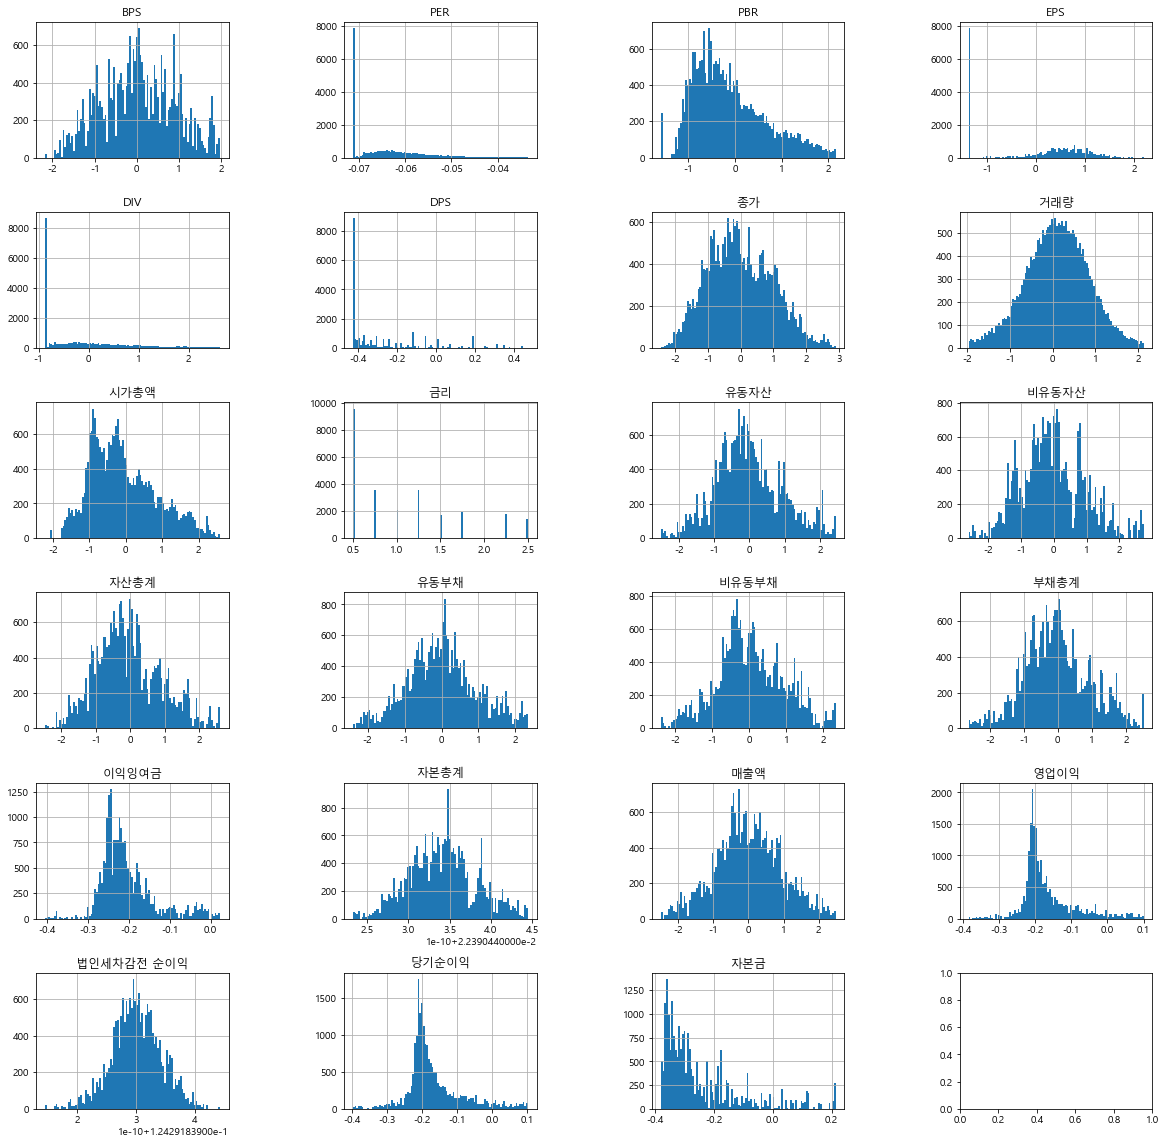

In [10]:
print_x_features(x_normalized_valid)

In [11]:
x_normalized_train.to_csv('./data/track1/features/x_train.csv', index=False)
x_normalized_valid.to_csv('./data/track1/features/x_valid.csv', index=False)
x_normalized_test.to_csv('./data/track1/features/x_test.csv', index=False)
y_train.to_csv('./data/track1/features/y_train.csv', index=False)
y_valid.to_csv('./data/track1/features/y_valid.csv', index=False)
y_test.to_csv('./data/track1/features/y_test.csv', index=False)